Deep Neural Network approach to the downstream tracking.
====================

The baseline to beat
* BDT 0.80457111174771212 
* Logistic Regresion 0.76763467806915342
-------------

In [1]:
import root_numpy
import pandas as pd
import numpy
import numpy as np
import matplotlib.pyplot as plt
import ROOT
%matplotlib inline

import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns

from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn import cross_validation
from sklearn.preprocessing import PolynomialFeatures
from sklearn.learning_curve import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.learning_curve import validation_curve

import theano
import theano.tensor as T
import lasagne
from lasagne.layers import InputLayer, DenseLayer, batch_norm, dropout

import time

Welcome to ROOTaaS 6.06/02
Couldn't import dot_parser, loading of dot files will not be possible.


As a very first step I need to grab training data form the NTpule. 
--------------------------

In [2]:
root_file = ROOT.TFile("datasets/Brunel_test_30kev.root")
root_file.cd("ToolSvc.PatDebugTTTruthTool")
tree = ROOT.gDirectory.Get("DownstreamSeedDebugTuple")
data = pd.DataFrame(root_numpy.tree2array(tree, stop=1000000))

target = data.is_true_seed
features = data.drop("is_true_seed", axis=1).astype(numpy.float64)

In [3]:
def replace_transforamtion(data):
    #abs transformation
    out = data
    out["seed_x"]=numpy.abs(data['seed_x'])
    out["seed_y"]=numpy.abs(data['seed_y'])
    out["seed_tx"]=numpy.abs(data['seed_tx'])
    out["seed_ty"]=numpy.abs(data['seed_ty'])
    #log transformation
    out["seed_p"]= numpy.log(data['seed_p'])
    out["seed_pt"]= numpy.log(data['seed_pt'])
    return out

In [4]:
data = replace_transforamtion(data)
features = data.drop("is_true_seed", axis=1).astype(numpy.float64)
features.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
0,1.213708,7.841285,7.079410,25,0,12,1263.157617,517.249191,0.524220,0.061572
1,1.346112,7.930741,7.093734,25,0,12,1264.522435,99.363473,0.480288,0.009081
2,1.627632,8.469986,7.443378,25,0,12,1521.093160,196.064807,0.382802,0.025975
3,1.789231,8.556975,7.508752,25,0,12,1563.145597,483.850246,0.369674,0.058753
4,1.269238,7.741082,7.132965,24,0,12,1641.727752,411.084316,0.646627,0.054980


In [30]:
data.head(-1)

,is_true_seed,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
0,False,1.213708,7.841285,7.079410,25,0,12,1263.157617,517.249191,0.524220,0.061572
1,False,1.346112,7.930741,7.093734,25,0,12,1264.522435,99.363473,0.480288,0.009081
2,False,1.627632,8.469986,7.443378,25,0,12,1521.093160,196.064807,0.382802,0.025975
3,False,1.789231,8.556975,7.508752,25,0,12,1563.145597,483.850246,0.369674,0.058753
4,True,1.269238,7.741082,7.132965,24,0,12,1641.727752,411.084316,0.646627,0.054980
5,False,1.646970,7.659698,6.930644,24,0,12,993.567378,106.608282,0.550439,0.015740
6,True,3.169295,8.386088,6.344725,24,0,12,425.754459,489.040514,0.118086,0.056625
7,True,0.490428,8.328650,7.262564,23,0,12,1235.285461,196.523106,0.365561,0.029957
8,False,0.704287,7.977368,7.070509,23,0,12,877.791302,1066.157189,0.423905,0.122942
9,True,0.877675,8.291765,7.256611,23,0,12,516.155250,1495.659576,0.305948,0.225284


Print the features
-------------------------

In [31]:
features.describe()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1.000000e+06
mean,2.141347,8.833942,7.059379,17.798359,2.588307,11.170937,533.741988,377.738345,2.451726e-01,5.026419e-02
std,1.445885,1.057322,0.531133,4.677713,4.628399,1.080211,446.983978,414.065479,2.053898e-01,5.273417e-02
min,0.000250,7.014427,0.566490,8.000000,0.000000,8.000000,0.000335,0.003038,6.751209e-07,2.967593e-08
25%,1.050588,8.013059,6.839000,13.000000,0.000000,11.000000,168.223014,90.798454,7.751869e-02,1.283386e-02
50%,1.703319,8.658668,7.024871,19.000000,0.000000,12.000000,398.655165,215.446883,1.845467e-01,3.118654e-02
75%,2.927111,9.487153,7.222911,22.000000,4.000000,12.000000,803.744816,516.092286,3.700074e-01,6.957887e-02
max,8.999711,20.826146,18.708738,32.000000,22.000000,12.000000,2505.840240,2277.240338,1.284890e+00,5.908304e-01


In [6]:
def print_features_histograms(Xdata, target):
    hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
    # create the figure
    fig = plt.figure(figsize=(16,  25))
    for n, feature in enumerate(Xdata):
        # add sub plot on our figure
        ax = fig.add_subplot(Xdata.shape[1] // 5 + 1, 6, n + 1)
        # define range for histograms by cutting 1% of data from both ends
        min_value, max_value = numpy.percentile(Xdata[feature], [1, 99])
        ax.hist(Xdata.ix[target == 0, feature].values, range=(min_value, max_value), 
                 label='ghost', **hist_params)
        ax.hist(Xdata.ix[target == 1, feature].values, range=(min_value, max_value), 
                 label='true', **hist_params)
        ax.legend(loc='best')

        ax.set_title(feature)

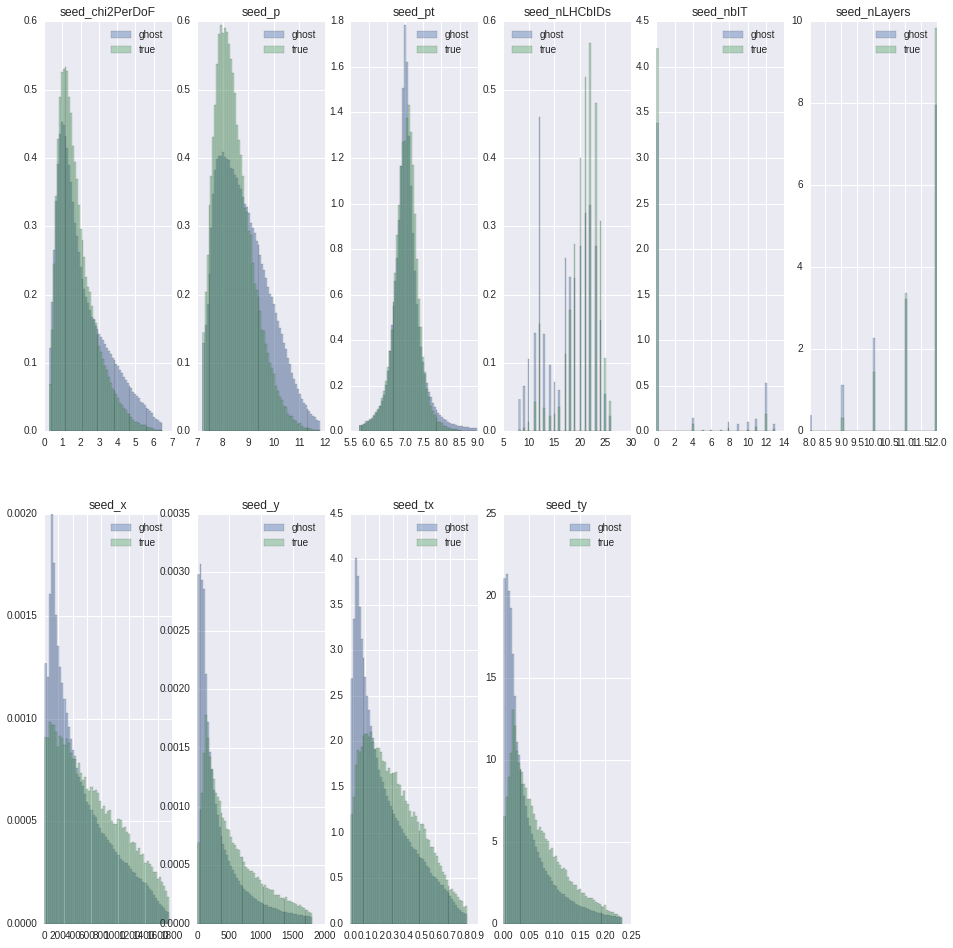

In [32]:
print_features_histograms(features, target)

In [6]:
data_scaled = StandardScaler().fit_transform(features)
scaled_features = pd.DataFrame(data_scaled)

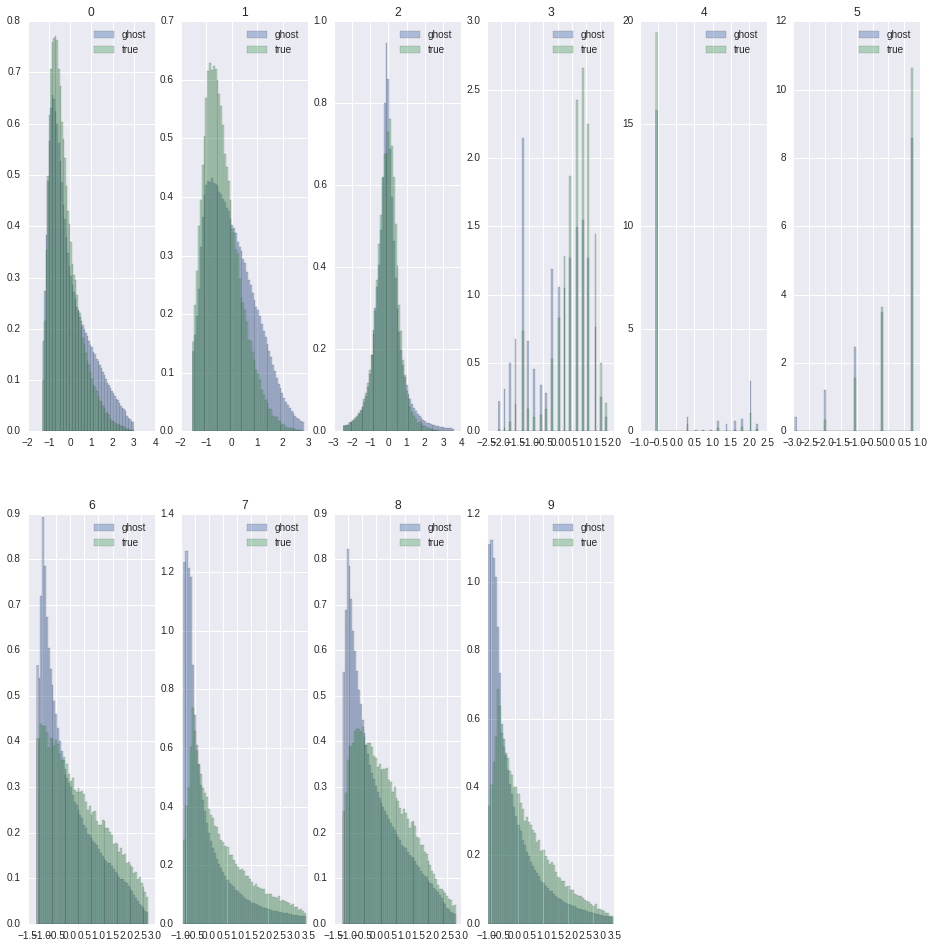

In [34]:
print_features_histograms(scaled_features, target)

Training of the basic version of the Deep Neural Network
=======================
I take a simple NN with 3 hidden layers:
* Layers must contain 500 hidden units each
* Layers must use tanh nonlinearity
* dropout probablilty set to 3

structure can be farther optimized, so feel free to experiment after you got it working

Split data into train and validation sets
----------------------

In [6]:
y = data['is_true_seed'].values==1
X = scaled_features[scaled_features.columns[1:]].values.astype(theano.config.floatX)

In [7]:
X_train,X_val,y_train,y_val = train_test_split(X,y,random_state=11, train_size=0.5)

In [8]:
input_X = T.matrix('input X')
target_Y = T.ivector('target Y')

Build the NN architecture
--------------------------

In [38]:
n_features = len(scaled_features.columns.values)-1
n_hid = 500
p_drop = 0.2

In [39]:
l_in = InputLayer([None, n_features],input_X,'input layer')

l_0 = lasagne.layers.BatchNormLayer(l_in, name="l_0")

l_1 = batch_norm(DenseLayer(l_0,
                num_units=n_hid,
                name='dense0',
                nonlinearity=lasagne.nonlinearities.tanh))

d_1 = dropout(l_1, p=p_drop)

l_2 = batch_norm(DenseLayer(d_1,
                num_units=n_hid,
                name='dense1',
                nonlinearity=lasagne.nonlinearities.tanh))

d_2 = dropout(l_2, p=p_drop)

l_3 = batch_norm(DenseLayer(d_2,
                num_units=n_hid,
                name='dense2',
                nonlinearity=lasagne.nonlinearities.tanh))

nn = DenseLayer(l_3,num_units=2,
                name='dense_out',
                nonlinearity=lasagne.nonlinearities.softmax,)

In [40]:
weights = lasagne.layers.get_all_params(nn,trainable=True)
weights

[l_0.beta,
 l_0.gamma,
 dense0.W,
 dense0_bn.beta,
 dense0_bn.gamma,
 dense1.W,
 dense1_bn.beta,
 dense1_bn.gamma,
 dense2.W,
 dense2_bn.beta,
 dense2_bn.gamma,
 dense_out.W,
 dense_out.b]

In [41]:
nn_out = lasagne.layers.get_output(nn)
loss = lasagne.objectives.categorical_crossentropy(nn_out, target_Y).mean()

In [42]:
updates =lasagne.updates.adadelta(loss,weights)
train_fun = theano.function([input_X,target_Y],[loss,nn_out[:,1]],updates=updates)

In [43]:
det_nn_out = lasagne.layers.get_output(nn,deterministic=True)
det_loss = lasagne.objectives.categorical_crossentropy(det_nn_out,target_Y).mean()
val_fun = theano.function([input_X,target_Y],[det_loss,nn_out[:,1]])

training loop
--------------

In [18]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=True):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [23]:
train_auc_curve = []
train_acc_curve = []
val_auc_curve = []
val_acc_curve = []

In [49]:
num_epochs = 3
batch_size = 1000
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    print ("start epoch %d"%epoch)
    start_time = time.time()
    
    train_err = 0
    Ypred_batches = []
    Ytrue_batches = []
    train_batches = 0
    
    for batch in iterate_minibatches(X_train, y_train, batch_size, shuffle=True):
        inputs, targets = batch
        err, y_pred = train_fun(inputs, targets)
                
        Ypred_batches.append(y_pred)
        Ytrue_batches.append(targets)
        if train_batches % 100 == 0:
            print("train batch %d"%train_batches)
        
        train_err += err
        train_batches += 1
    
    Ypred_train = np.concatenate(Ypred_batches)
    Ytrue_train = np.concatenate(Ytrue_batches)
    train_acc = accuracy_score(Ytrue_train, Ypred_train>0.5)
    train_auc = roc_auc_score(Ytrue_train, Ypred_train)
    
    train_acc_curve.append(train_acc)
    train_auc_curve.append(train_auc)

    print ("start validation")
    # And a full pass over the validation data:
    val_err = 0
    Ypred_batches = []
    Ytrue_batches = []
    val_batches = 0
    
    for batch in iterate_minibatches(X_val, y_val, batch_size, shuffle=False):
        inputs, targets = batch
        err, y_pred = val_fun(inputs, targets)
        Ypred_batches.append(y_pred)
        Ytrue_batches.append(targets)
        if val_batches % 100 == 0:
            print("val batch %d"%val_batches)
        
        val_err += err
        val_batches += 1

    Ypred_val = np.concatenate(Ypred_batches)
    Ytrue_val = np.concatenate(Ytrue_batches)
    val_acc = accuracy_score(Ytrue_val, Ypred_val>0.5)
    val_auc = roc_auc_score(Ytrue_val, Ypred_val)
    
    val_acc_curve.append(val_acc)
    val_auc_curve.append(val_auc)


    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  training accuracy:\t\t{:.2f} %".format(
        train_acc * 100))
    print("  training AUCscore:\t\t{:.2f} %".format(
        train_auc * 100))
    print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc  * 100))
    print("  validation AUCscore:\t\t{:.2f} %".format(
        val_auc * 100))

start epoch 0
train batch 0
train batch 100
train batch 200
train batch 300
train batch 400
start validation
val batch 0
val batch 100
val batch 200
val batch 300
val batch 400
Epoch 1 of 3 took 1873.960s
  training loss:		0.222292
  training accuracy:		93.57 %
  training AUCscore:		71.70 %
  validation loss:		0.233704
  validation accuracy:		92.55 %
  validation AUCscore:		72.90 %
start epoch 1
train batch 0
train batch 100
train batch 200
train batch 300
train batch 400
start validation
val batch 0
val batch 100
val batch 200
val batch 300
val batch 400
Epoch 2 of 3 took 1993.340s
  training loss:		0.217011
  training accuracy:		93.56 %
  training AUCscore:		73.88 %
  validation loss:		0.245169
  validation accuracy:		93.58 %
  validation AUCscore:		70.92 %
start epoch 2
train batch 0
train batch 100
train batch 200
train batch 300
train batch 400
start validation
val batch 0
val batch 100
val batch 200
val batch 300
val batch 400
Epoch 3 of 3 took 2028.082s
  training loss:		0.21363

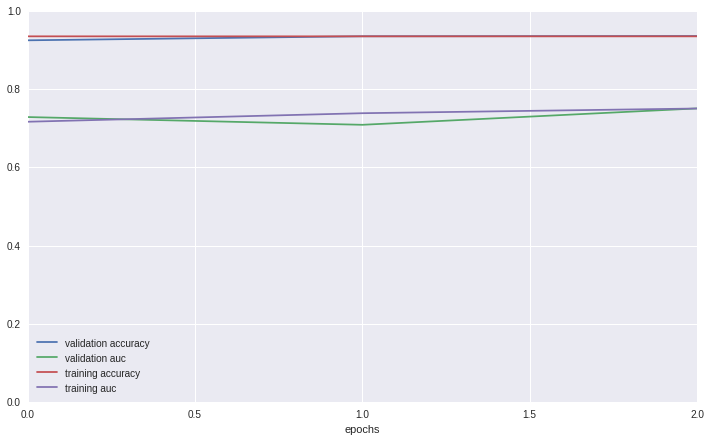

In [52]:
plt.figure(figsize=(12, 7))
plt.plot(val_acc_curve,label='validation accuracy')
plt.plot(val_auc_curve,label='validation auc')
plt.plot(train_acc_curve,label='training accuracy')
plt.plot(train_auc_curve,label='training auc')
plt.xlabel("epochs")
plt.legend(loc='best')
plt.ylim(0,1);

Try differnt model ReLu with 5 layers

In [9]:
n_features = len(scaled_features.columns.values)-1
n_hid = 500
p_drop = 0.2

In [10]:

l_in = InputLayer([None, n_features],input_X,'input layer')

l_0 = lasagne.layers.BatchNormLayer(l_in, name="l_0")

l_1 = batch_norm(DenseLayer(l_0,
                num_units=n_hid,
                name='dense0',
                nonlinearity=lasagne.nonlinearities.tanh))

d_1 = dropout(l_1, p=p_drop)

l_2 = batch_norm(DenseLayer(d_1,
                num_units=n_hid,
                name='dense1',
                nonlinearity=lasagne.nonlinearities.tanh))

d_2 = dropout(l_2, p=p_drop)

l_3 = batch_norm(DenseLayer(d_2,
                num_units=n_hid,
                name='dense2',
                nonlinearity=lasagne.nonlinearities.tanh))

d_3 = dropout(l_3, p=p_drop)

l_4 = batch_norm(DenseLayer(d_3,
                num_units=n_hid,
                name='dense3',
                nonlinearity=lasagne.nonlinearities.tanh))

d_4 = dropout(l_4, p=p_drop)

l_5 = batch_norm(DenseLayer(d_4,
                num_units=n_hid,
                name='dense4',
                nonlinearity=lasagne.nonlinearities.tanh))

nn = DenseLayer(l_5,num_units=2,
                name='dense_out',
                nonlinearity=lasagne.nonlinearities.softmax,)

In [13]:
weights = lasagne.layers.get_all_params(nn,trainable=True)
weights

[l_0.beta,
 l_0.gamma,
 dense0.W,
 dense0_bn.beta,
 dense0_bn.gamma,
 dense1.W,
 dense1_bn.beta,
 dense1_bn.gamma,
 dense2.W,
 dense2_bn.beta,
 dense2_bn.gamma,
 dense3.W,
 dense3_bn.beta,
 dense3_bn.gamma,
 dense4.W,
 dense4_bn.beta,
 dense4_bn.gamma,
 dense_out.W,
 dense_out.b]

In [14]:
nn_out = lasagne.layers.get_output(nn)
loss = lasagne.objectives.categorical_crossentropy(nn_out, target_Y).mean()

In [15]:
updates =lasagne.updates.adadelta(loss,weights)
train_fun = theano.function([input_X,target_Y],[loss,nn_out[:,1]],updates=updates)

In [16]:
det_nn_out = lasagne.layers.get_output(nn,deterministic=True)
det_loss = lasagne.objectives.categorical_crossentropy(det_nn_out,target_Y).mean()
val_fun = theano.function([input_X,target_Y],[det_loss,nn_out[:,1]])

In [25]:
num_epochs = 5
batch_size = 1000
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    print ("start epoch %d"%epoch)
    start_time = time.time()
    
    train_err = 0
    Ypred_batches = []
    Ytrue_batches = []
    train_batches = 0
    
    for batch in iterate_minibatches(X_train, y_train, batch_size, shuffle=True):
        start_epoch =  time.time()
        inputs, targets = batch
        err, y_pred = train_fun(inputs, targets)
                
        Ypred_batches.append(y_pred)
        Ytrue_batches.append(targets)
        if train_batches % 100 == 0:
            print("train batch %d"%train_batches)
            print ("took time %d(s)"%(time.time() - start_epoch))
            
        train_err += err
        train_batches += 1
    
    Ypred_train = np.concatenate(Ypred_batches)
    Ytrue_train = np.concatenate(Ytrue_batches)
    train_acc = accuracy_score(Ytrue_train, Ypred_train>0.5)
    train_auc = roc_auc_score(Ytrue_train, Ypred_train)
    
    train_acc_curve.append(train_acc)
    train_auc_curve.append(train_auc)

    print ("start validation")
    # And a full pass over the validation data:
    val_err = 0
    Ypred_batches = []
    Ytrue_batches = []
    val_batches = 0
    
    for batch in iterate_minibatches(X_val, y_val, batch_size, shuffle=False):
        start_epoch =  time.time()
        inputs, targets = batch
        err, y_pred = val_fun(inputs, targets)
        Ypred_batches.append(y_pred)
        Ytrue_batches.append(targets)
        if val_batches % 100 == 0:
            print("val batch %d"%val_batches)
            print ("took time %d(s)"%(time.time() - start_epoch))

        val_err += err
        val_batches += 1

    Ypred_val = np.concatenate(Ypred_batches)
    Ytrue_val = np.concatenate(Ytrue_batches)
    val_acc = accuracy_score(Ytrue_val, Ypred_val>0.5)
    val_auc = roc_auc_score(Ytrue_val, Ypred_val)
    
    val_acc_curve.append(val_acc)
    val_auc_curve.append(val_auc)


    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  training accuracy:\t\t{:.2f} %".format(
        train_acc * 100))
    print("  training AUCscore:\t\t{:.2f} %".format(
        train_auc * 100))
    print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc  * 100))
    print("  validation AUCscore:\t\t{:.2f} %".format(
        val_auc * 100))

start epoch 0
train batch 0
took time 4(s)
train batch 100
took time 4(s)
train batch 200
took time 4(s)
train batch 300
took time 4(s)
train batch 400
took time 4(s)
start validation
val batch 0
took time 1(s)
val batch 100
took time 1(s)
val batch 200
took time 1(s)
val batch 300
took time 1(s)
val batch 400
took time 1(s)
Epoch 1 of 5 took 2991.581s
  training loss:		0.211041
  training accuracy:		93.57 %
  training AUCscore:		76.04 %
  validation loss:		0.215218
  validation accuracy:		93.63 %
  validation AUCscore:		73.83 %
start epoch 1
train batch 0
took time 4(s)
train batch 100
took time 4(s)
train batch 200
took time 4(s)
train batch 300
took time 4(s)
train batch 400
took time 4(s)
start validation
val batch 0
took time 1(s)
val batch 100
took time 1(s)
val batch 200
took time 1(s)
val batch 300
took time 1(s)
val batch 400
took time 1(s)
Epoch 2 of 5 took 2982.712s
  training loss:		0.209827
  training accuracy:		93.58 %
  training AUCscore:		76.40 %
  validation loss:		0.2

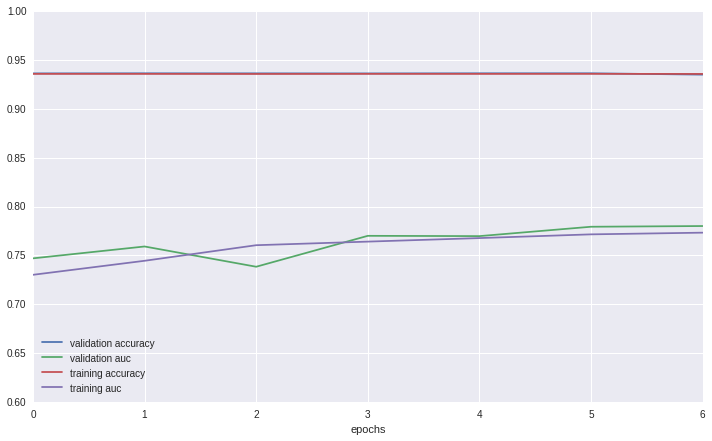

In [27]:
plt.figure(figsize=(12, 7))
plt.plot(val_acc_curve,label='validation accuracy')
plt.plot(val_auc_curve,label='validation auc')
plt.plot(train_acc_curve,label='training accuracy')
plt.plot(train_auc_curve,label='training auc')
plt.xlabel("epochs")
plt.legend(loc='best')
plt.ylim(0.6,1);

Keras based DNN
=================
Let's try anoyther Deep Neural Network Framweork and compare the reslut. I try to build similar network but this time I want to use such parameters as:
* Number of Hidden Layers - 3
* Number of hidden unit per layer- 500
* nonlinearity ReLu

In [6]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.advanced_activations import PReLU
from keras.utils import np_utils

Using Theano backend.


In [7]:
def model_factory(n_inputs):
    n_unit = 500
    model = Sequential()
    # first
    model.add(Dense(n_unit,input_dim=n_inputs))
    model.add(PReLU(input_shape=(n_unit,)))
    model.add(Dropout(0.5))
    # second
    model.add(Dense(n_unit,input_dim=n_unit))
    model.add(PReLU(input_shape=(n_unit,)))
    model.add(Dropout(0.5))
    #third
    model.add(Dense(n_unit,input_dim=n_unit))
    model.add(PReLU(input_shape=(n_unit,)))
    model.add(Dropout(0.5))
    #output
    model.add(Dense(2, input_dim=n_unit))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',  optimizer='rmsprop')
    return model

In [8]:
data_scaled = StandardScaler().fit_transform(features)
X_train,X_val,y_train,y_val = train_test_split(data_scaled,target,random_state=11, train_size=0.9)
y_train = np_utils.to_categorical(y_train.values)
y_val = np_utils.to_categorical(y_val.values)

In [ ]:
n_input =X_train.shape[1]
print("number of input features %d"%n_input)
model = model_factory(n_input)
n_epochs = 5
batch_size = 256
model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=n_epochs, validation_data=(X_val, y_val), verbose=2, show_accuracy=True)

number of input features 10
Train on 900000 samples, validate on 100000 samples
Epoch 1/5
